# Analisis de sentimiento en reseñas de peliculas de IMDB para Film Junky Union usando NLTK, spaCy, vectorizador tf-idf, regresion logistica y LGBM Clasificador

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, busca desarrollar un sistema para filtrar y categorizar reseñas de películas. El objetivo aqui es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, se utilizara un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

Comenzaremos importando las librerias a utilizar, seguido de la carga de nuestros datos examinandolos en busqueda de errores en los formatos o valores ausentes, despues realizaremos un EDA, para continuar con el preprocesamiento de los datos para el entrenamiento y prueba de los modelos, se probaran en ambos conjuntos evaluando su desempeño en F1 score, APS y ROC-AUC, de igual manera se realizara lo mismo con algunas reseñas que no estan en los conjuntos de datos con los que se trabajara.

## Inicialización

Iniciamos importando las librerias para visualizar los datos y realizar el EDA

In [83]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [84]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [85]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [86]:
# Carga del set de datos
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [87]:
# Visualizacion de informacion, metricas y set de datos
display(df_reviews.info())
display(df_reviews.describe())
display(df_reviews.shape)
df_reviews

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

None

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


(47331, 17)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


Tenemos la informacion de las reseñas hechas a las peliculas y series de tv, su tipo, nombre, el año de lanzamiento, la duracion, si es contenido solo para adultos, genero, el rating promedio, numero de votos y nuestros datos mas relevantes, la reseña, el rating, si la reseña fue con sentimiento positivo o negativo y a que conjunto pertenece dicha reseña, si es de entrenamuiento o prueba. Los datos se ven bastante uniformes y en el formato correcto a excepcion de dos valores ausentes en las columnas de rating promedio que puede indicar algun error o que no existio una votacion para dicha reseña.

In [88]:
df_reviews[df_reviews['average_rating'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Podemos ver que en efecto esas reseñas tienen valores ausentes en votos y promedio de votos, lo que nos indica algun error o que simplemente no se voto para esas reseñas, como nuestro analisis no se enfoca en los votos sino en las reseñas y su sentimiento, no se eliminara ni imputaran las reseñas.

## EDA

Comenzaremos a realizar el EDA. Veamos el número de películas y reseñas a lo largo de los años.

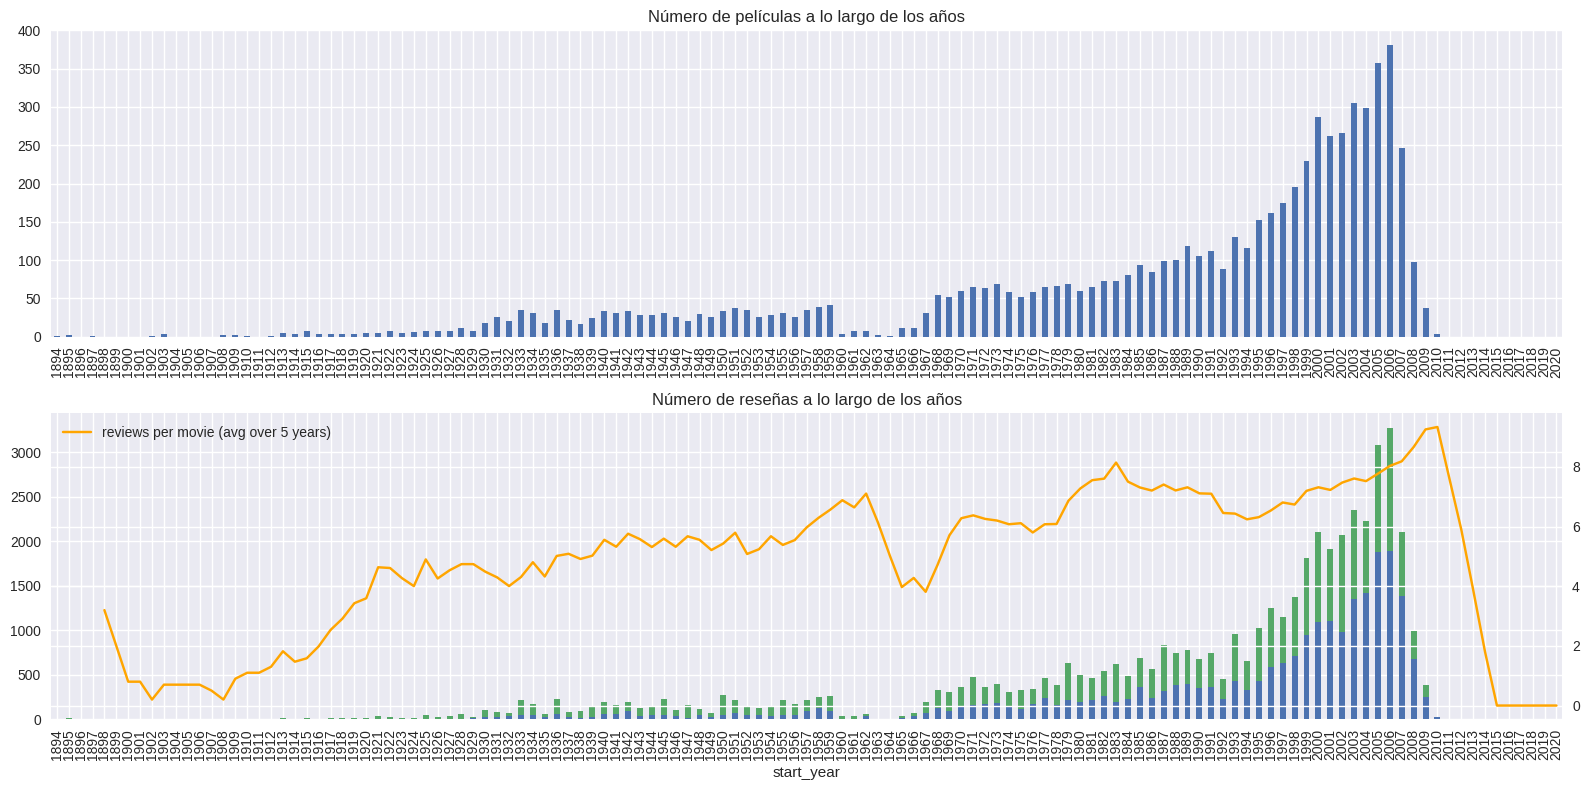

In [89]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Podemos ver que el numero de peliculas ha tenido un incremento a lo largo de los años siendo su pico mas alto en el 2006, este crecimiento fue mas pronunciado a partir del año de 1987 hasta el 2008. Aunque se puede apreciar en su mayor parte una tendencia a crecer en el numero de reseñas, este crecimiento no es tan pronunciado como el numero de peliculas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

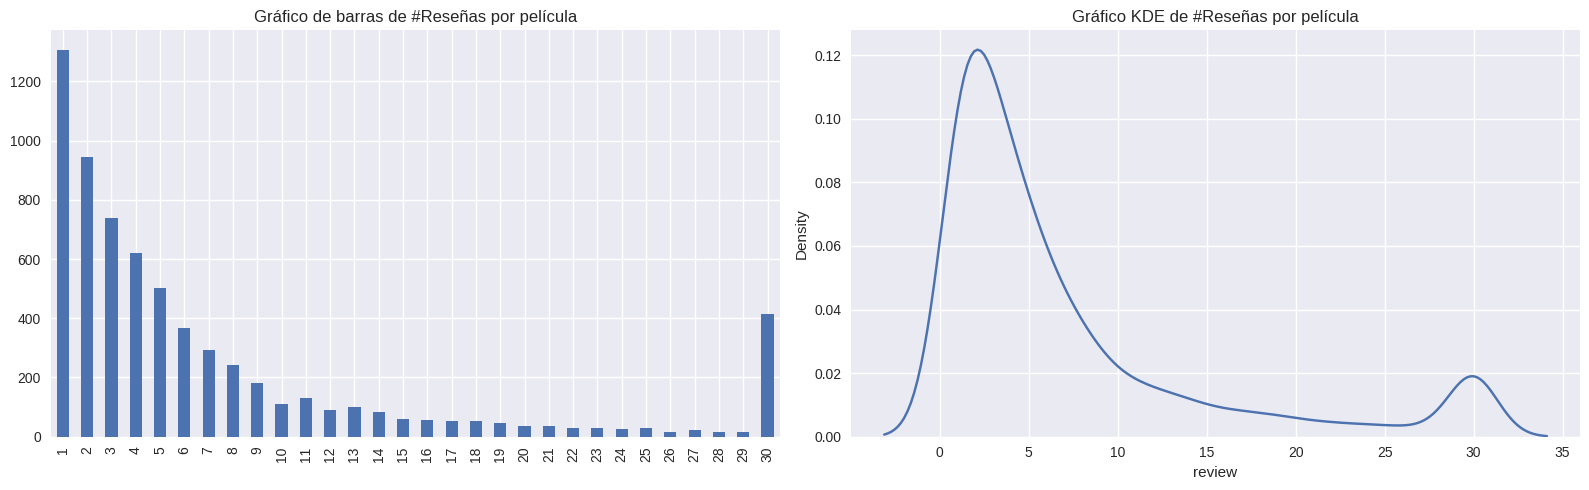

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Podemos ver una mayor densidad en aquellas peliculas que solo tienen de 1 a 6 reseñas, aunque tambien hay otro pico importante en peliculas que tienen 6 reseñas.

Veamos el balance de clases que existe en todo el conjunto de datos

In [91]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Tenemos clases con una ligera diferencia pero no la suficiente como para decir que tenemos un desbalance.

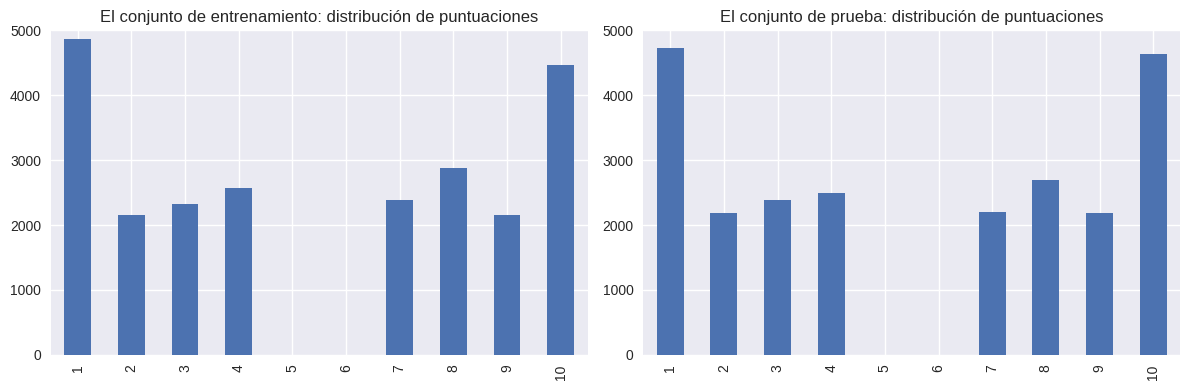

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Tenemos una distribucion en las calificaciones bastante igual en los conjuntos de entrenamiento y prueba, y esta a su vez tiene un patron similar teniendo las calificaciones del 2 al 9 dentro de las 2000 a 3000 reseñas, (a excepcion de 5 y 6 que son calificaciones que no tenemos en nuestro set de datos) y para las calificaciones de 1 y 10 se tienen arriba de las 4400 reseñas.

Veamos la distribución de reseñas negativas y positivas a lo largo de los años para las dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


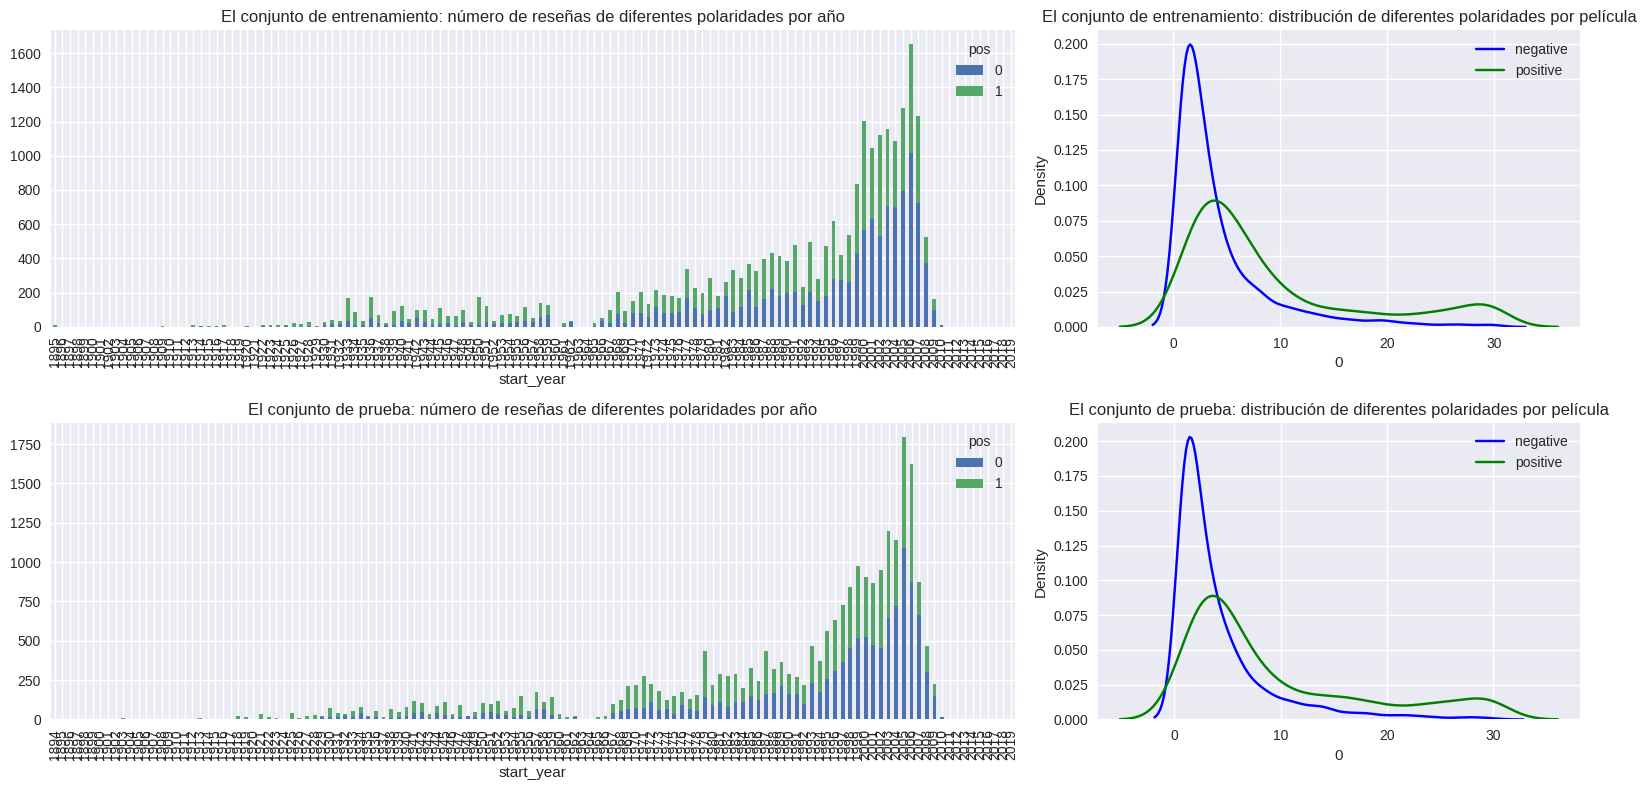

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Se observa un incremento del numero de reseñas a partir de los años de 1995 , aunque tenemos una ligera predominacion de reseñas positivas esta no es execiva. Tenemos una mayor densidad de reseñas negativas en valores bajos lo que nos dice que la mayoria de peliculas no recibe valoraciones malas, pero algunas pueden tener una cantidad cosniderable. 

## Conclusiones generales del EDA

**Crecimiento en el número de reseñas y películas**
Se ha observado un incremento en el número de películas con el paso del tiempo, especialmente desde 1987 hasta 2008, con un pico en 2006. Aunque el número de reseñas también ha crecido, este incremento no es proporcional al número de películas, lo que sugiere que algunas películas reciben muchas más reseñas que otras.

**Distribucion de las reseñas**
Las reseñas positivas son ligeramente más numerosas que las negativas, pero la diferencia es mínima (23,715 negativas vs. 23,616 positivas), lo que evita un problema de desbalance de clases.
La densidad de reseñas negativas es mayor en valores bajos, lo que indica que la mayoría de las películas no reciben muchas reseñas negativas, pero algunas pocas sí concentran un número considerable de críticas negativas.

**Distribución de las calificaciones y patrones observados**
En ambos conjuntos (entrenamiento y prueba), las calificaciones siguen un patrón similar, con la mayoría de las reseñas situadas entre 2 y 9.
Las calificaciones de 1 y 10 son las más frecuentes, con más de 4,400 reseñas cada una, lo que sugiere que los usuarios suelen dejar opiniones extremas en lugar de valoraciones intermedias.

Los datos están bien distribuidos para entrenar un modelo de clasificación de reseñas con polaridad positiva o negativa. El leve desequilibrio en las clases no es un problema significativo, lo que permitirá evaluar los modelos sin necesidad de aplicar técnicas de balanceo. Sin embargo, será crucial considerar la ausencia de calificaciones de 5 y 6, así como el comportamiento de las reseñas extremas, al entrenar el modelo.

El siguiente paso es proceder con el preprocesamiento de los datos y la construcción del modelo de clasificación, priorizando que alcance un F1-score de al menos 0.85 como meta establecida.


## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [94]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')  
        

        #eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc. Por lo que se nromalizaran las reseñas bajo este formato.

In [95]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')
df_reviews[['review', 'review_norm']]

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenti...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in...
4,I'm totally agree with GarryJohal from Singapo...,i m totally agree with garryjohal from singapo...
...,...,...
47326,This is another of my favorite Columbos. It sp...,this is another of my favorite columbos it sp...
47327,Talk about being boring! I got this expecting ...,talk about being boring i got this expecting ...
47328,"I never thought I'd say this about a biopic, b...",i never thought i d say this about a biopic b...
47329,Spirit and Chaos is an artistic biopic of Miya...,spirit and chaos is an artistic biopic of miya...


## División entrenamiento / prueba

El conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [96]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

Entrenaremos 3 modelos y uno Dummy como prueba de cordura, en el primer modelo se utilizara NLTK(Natural Lengual ToolKit) con tf-idf vectorizer y regresion logistica, el segundo con spaCy, tf-idf vectorier y regresion logistica, y por utlimo el tercer modelo con spaCy, tf-idf vectorizer y Lgbm Classifier.

### Modelo 0 - Constante

In [97]:
from sklearn.dummy import DummyClassifier

In [98]:
# Creacion del modelo dummy
dummy_model = DummyClassifier(strategy = 'constant', constant = 1)

In [99]:
# Entrenamiento de modelo
trained_dummy_model = dummy_model.fit(df_reviews_train, train_target)

         train  test
F1        0.67  0.67
APS       0.50  0.50
ROC AUC   0.50  0.50


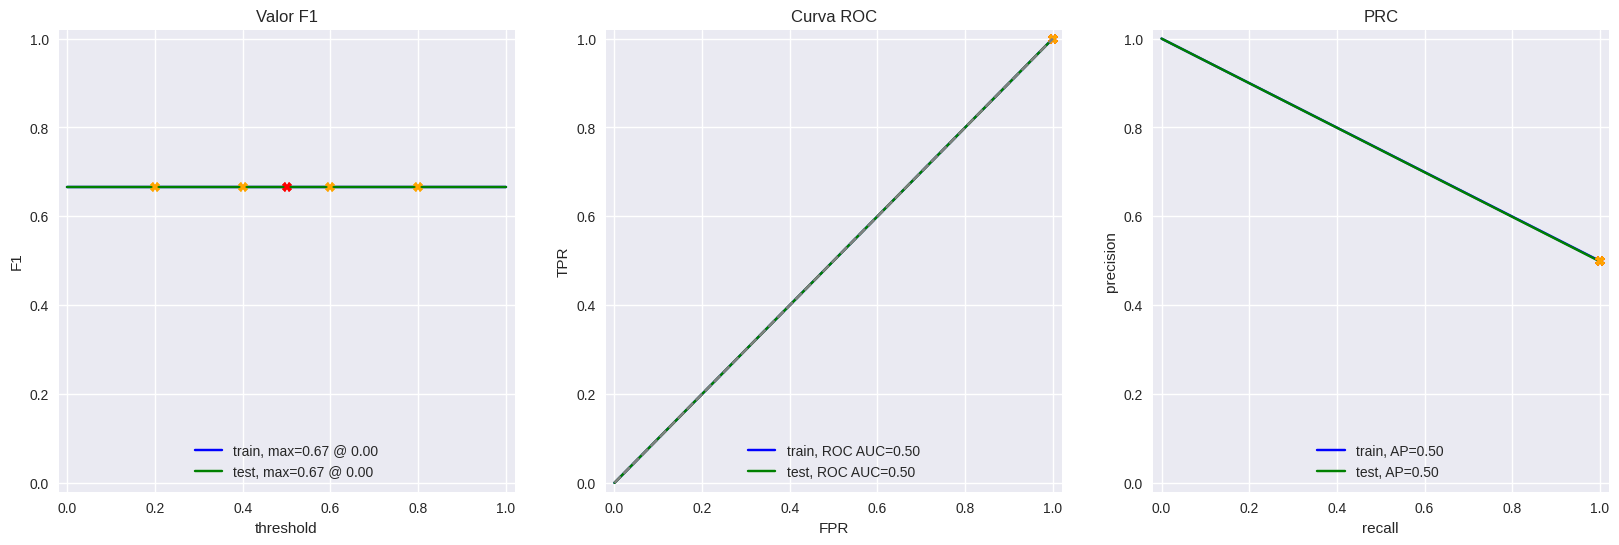

In [100]:
# Evaluacion del modelo
evaluate_model(trained_dummy_model, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

Tenemos nuestro modelo constante el cual alcanzo un F1 de 0.67, para el conjunto de entrenamiento y prueba, APS y ROC-AUC de 0.5 para ambos conjuntos, con esto, podemos comparar si los modelos se comportan mejor que un modelo aleatorio.

### Modelo 1 - NLTK, TF-IDF y LR

En este modelo usaremos NLTK, TF-IDF vectorizer y la regresion logistica para el analisis de sentimiento de las reseñas.

In [101]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [102]:
# Creacion del vectorizador td-idf
tfidf_vectorizer_1 = TfidfVectorizer(stop_words = stopwords.words('english'), lowercase = True)

In [103]:
# Vectorizacion de las caracteristicas de entrenamiento y prueba
train_features_vectorizer_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_vectorizer_1= tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])
# Mostrar tamaño de las matrices obtenidas
display(train_features_vectorizer_1.shape)
display(test_features_vectorizer_1.shape)

(23796, 71531)

(23535, 71531)

In [104]:
# Comprobar el tamaño de nuestro objetivo de entrenamiento y prueba
display(train_target.shape)
display(test_target.shape)

(23796,)

(23535,)

In [105]:
# Entrenamiento del modelo
lr_model_1 = LogisticRegression()
lr_model_1.fit(train_features_vectorizer_1, train_target)

LogisticRegression()

         train  test
F1        0.94  0.88
APS       0.98  0.95
ROC AUC   0.98  0.95


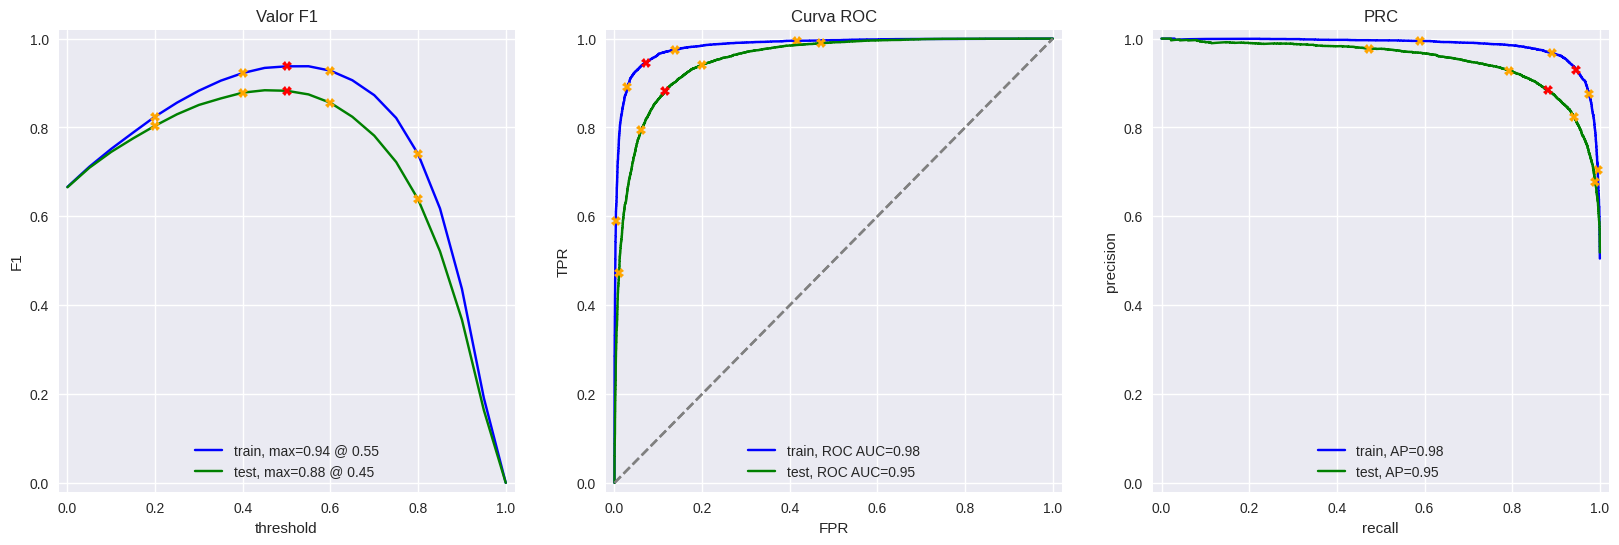

In [106]:
evaluate_model(lr_model_1, train_features_vectorizer_1, train_target, test_features_vectorizer_1, test_target)

Con NLTK, TD-IDF y la regresion logistica obtenemos un resultado de:F1 Score 0.94 y 0.88, APS de 0.98 y 0.95, ROC-AUC 0.98 y 0.95 para el conjunto de entrenamiento y prueba respectivamente.

### Modelo 2 - spaCy, TF-IDF y LR

Ahora, emplearemos spaCy para la tokenizacion de las reseñas, TF-IDF vectorizer y de igual forma la regresion logistica.


In [107]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [108]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [111]:
# Aplicar funcion de tokenizacion con spacy
df_reviews_train['review_tokenized_spacy'] = df_reviews_train['review_norm'].progress_apply(lambda fila: text_preprocessing_3(fila))
df_reviews_test['review_tokenized_spacy'] = df_reviews_test['review_norm'].progress_apply(lambda fila: text_preprocessing_3(fila))


  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [112]:
# Creacion del vectorizador td-idf
tfidf_vectorizer_2 = TfidfVectorizer(stop_words = stopwords.words('english'), lowercase = True)

In [113]:
# Vectorizacion de las caracteristicas de entrenamiento y prueba
train_features_vectorizer_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_tokenized_spacy'])
test_features_vectorizer_2= tfidf_vectorizer_2.transform(df_reviews_test['review_tokenized_spacy'])
# Mostrar tamaño de las matrices obtenidas
display(train_features_vectorizer_2.shape)
display(test_features_vectorizer_2.shape)

(23796, 59378)

(23535, 59378)

In [114]:
lr_model_2 = LogisticRegression()
lr_model_2.fit(train_features_vectorizer_2, train_target)

LogisticRegression()

         train  test
F1        0.93  0.88
APS       0.98  0.95
ROC AUC   0.98  0.95


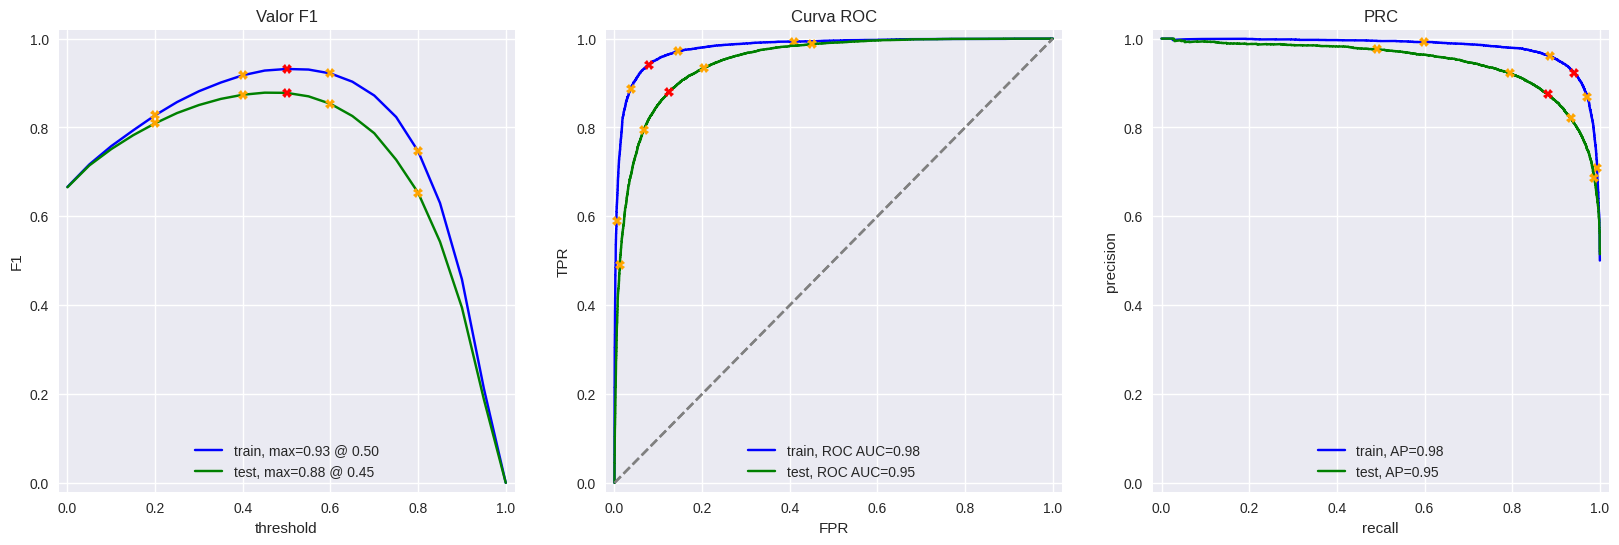

In [115]:
evaluate_model(lr_model_2, train_features_vectorizer_2, train_target, test_features_vectorizer_2, test_target)

Con spaCy, TD-IDF y la regresion logistica obtenemos un resultado de:F1 Score 0.93 y 0.88, APS de 0.98 y 0.95, ROC-AUC 0.98 y 0.95 para el conjunto de entrenamiento y prueba respectivamente.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

En este modelo utilizaremos spaCy y TF-IDF vectorizer como en el modelo anterior, a excepcion de no se usara la regresion logistica sino LGBM Classifier.

In [116]:
from lightgbm import LGBMClassifier

In [117]:
# Vectorizacion de las caracteristicas de entrenamiento y prueba
train_features_vectorizer_3 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_tokenized_spacy'])
test_features_vectorizer_3= tfidf_vectorizer_2.transform(df_reviews_test['review_tokenized_spacy'])
# Mostrar tamaño de las matrices obtenidas
display(train_features_vectorizer_3.shape)
display(test_features_vectorizer_3.shape)

(23796, 59378)

(23535, 59378)

In [118]:
# Hiperparametros tunneados al dataset
lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=7,
    num_leaves=20,
    boosting_type="gbdt",
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    random_state=42
)

In [119]:
lgbm_model.fit(train_features_vectorizer_3, train_target)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.03, max_depth=7,
               n_estimators=1000, num_leaves=20, random_state=42,
               reg_lambda=2.0, subsample=0.7)

         train  test
F1        0.94  0.86
APS       0.98  0.94
ROC AUC   0.98  0.94


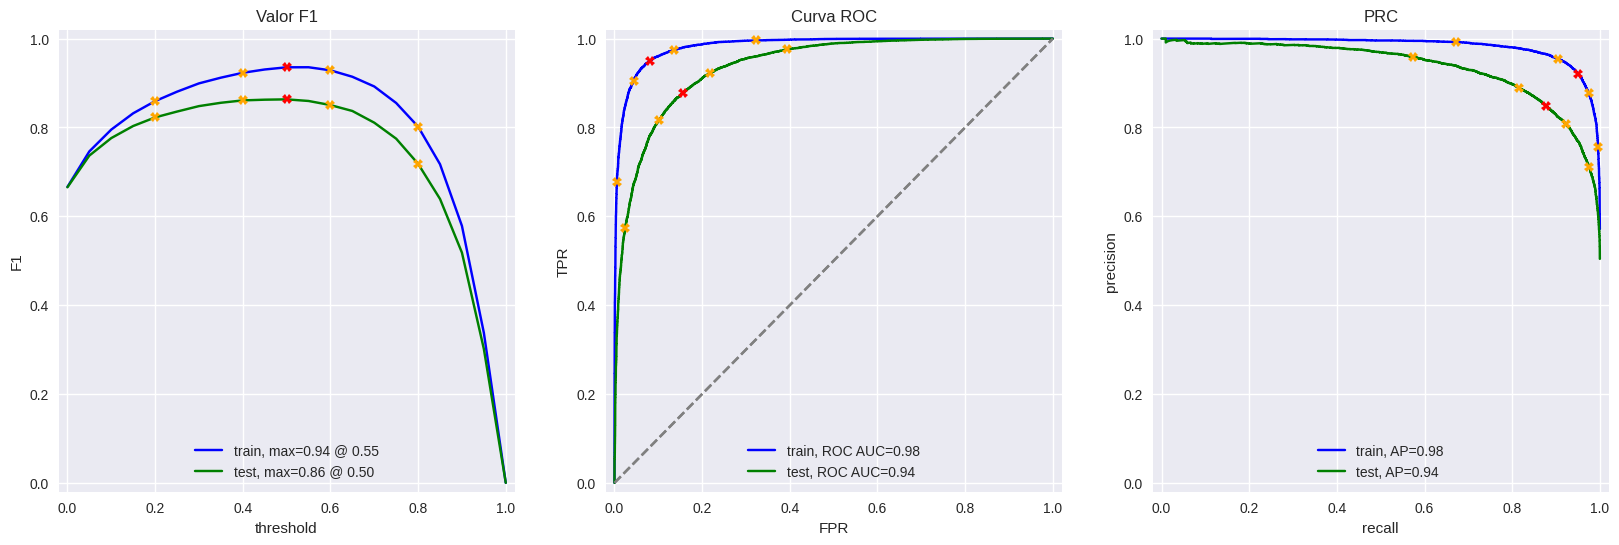

In [120]:
evaluate_model(lgbm_model, train_features_vectorizer_3, train_target, test_features_vectorizer_3, test_target)

Con spaCy, TD-IDF y LGBM Classifier obtenemos un resultado de:F1 Score 0.94 y 0.86, APS de 0.98 y 0.94, ROC-AUC 0.98 y 0.94 para el conjunto de entrenamiento y prueba respectivamente.

## Conclusiones generales de la evaluacion de los modelos

Todos los modelos superan ampliamente al modelo base, pero el mejor equilibrio entre rendimiento y generalización lo presentan los modelos de Regresión Logística con TF-IDF, ya sea utilizando NLTK o spaCy.

Debido a su F1-score de 0.88 en prueba y un excelente ROC-AUC de 0.95, la opción más recomendada sería la Regresión Logística con TF-IDF, dado que mantiene un buen desempeño sin una caída significativa entre entrenamiento y prueba. Además, es un modelo más interpretativo y eficiente en términos de tiempo de entrenamiento en comparación con LGBM.

Si se requiere velocidad y simplicidad, se recomienda optar por la Regresión Logística con NLTK + TF-IDF.
Si se busca una implementación más robusta en producción, la versión con spaCy + TF-IDF es una excelente alternativa.

## Mis reseñas

Con estos modelos, analisaremos el sentimiento de las siguientes reseñas las cuales no estan incluidas en ninguno de los sets de datos vistos anteriormente

In [121]:
# las reseñas que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


### Modelo 1 - NLTK, TF-IDF y LR

In [122]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


Observaciones:

Este modelo captura bien las reseñas negativas, asignando probabilidades bajas a frases como "What a rotten attempt at a comedy." (0.04) o "Even the actors looked really old and disinterested." (0.11).
Sin embargo, parece ser más conservador con las reseñas positivas, ya que frases como "I was really fascinated with the movie." reciben solo un 0.54, y "I didn’t expect the reboot to be so good!" apenas 0.31.
Su predicción en la reseña ambigua "The movie had its upsides and downsides, but overall it’s a decent flick." es 0.47, mostrando que tiene dificultades para decidir en opiniones mixtas.
Bueno en detectar negativas, pero conservador con positivas.



### Modelo 2  - spaCy, TF-IDF y LR

In [123]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it  not my kind of movie 
0.14:  well  i was bored and felt asleep in the middle of the movie 
0.48:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.26:  i didn t expect the reboot to be so good  writers really cared about the source material
0.51:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.92:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


Observaciones:

Similar al Modelo 1 en la asignación de bajas probabilidades a reseñas negativas ("What a rotten attempt at a comedy." con 0.04).
Sin embargo, es aún más conservador con reseñas positivas, asignando solo 0.48 a "I was really fascinated with the movie." y 0.26 a "I didn’t expect the reboot to be so good!".
Es el único modelo que da más de 0.50 a la reseña ambigua (0.51), mostrando una ligera tendencia a aceptar términos neutrales como positivos.
Más equilibrado en casos ambiguos, pero demasiado conservador con frases positivas.



### Modelo 3  - spaCy, TF-IDF y LGBMClassifier

In [124]:
texts = my_reviews['review_norm']


my_reviews_pred_prob = lgbm_model.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i did not simply like it  not my kind of movie 
0.41:  well  i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.43:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.62:  i didn t expect the reboot to be so good  writers really cared about the source material
0.68:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.32:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.76:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


Observaciones:

Es el más optimista con reseñas positivas, asignando 0.59 a "I was really fascinated with the movie." y 0.62 a "I didn’t expect the reboot to be so good!", valores más alineados con la intención del texto.
Sin embargo, es menos agresivo al identificar reseñas negativas, ya que "Even the actors looked really old and disinterested." tiene 0.43, lo que es alto para un comentario negativo.
A la reseña ambigua "The movie had its upsides and downsides, but overall it’s a decent flick." le da 0.68, inclinándose más por la interpretación positiva.
Mejor en positivas, pero menos preciso en identificar negativas.



## Conclusiones

Dado el objetivo del proyecto, que es identificar automáticamente las críticas negativas en las reseñas de películas, es crucial seleccionar un modelo que tenga alta precisión en la detección de comentarios negativos y que minimice los falsos positivos en reseñas positivas.

**Resumen del desempeño de los modelos**
**Modelo 1 (NLTK, TF-IDF, Regresión Logística)**

Sobresale en la detección de reseñas negativas, asignando probabilidades bajas a comentarios claramente negativos.
Es conservador con las reseñas positivas, lo que puede llevar a subestimar algunas críticas favorables.
Dificultades con opiniones mixtas, ya que tiende a clasificarlas como neutrales o negativas.


**Modelo 2 (spaCy, TF-IDF, Regresión Logística)**

También detecta bien las reseñas negativas y es más equilibrado en opiniones ambiguas.
Sin embargo, es aún más conservador con frases positivas, lo que puede afectar su capacidad de diferenciación.


**Modelo 3 (spaCy, TF-IDF, LGBMClassifier)**

Es el más optimista con reseñas positivas, asignando mayores probabilidades a frases con tono favorable.
Menos preciso al identificar reseñas negativas, ya que asigna valores más altos a comentarios que deberían ser clasificados como negativos.
Puede confundir críticas negativas con comentarios neutrales o positivos.


**Recomendación final**

Si la prioridad es identificar con alta precisión las reseñas negativas y evitar falsos positivos en reseñas positivas, el Modelo 1 (NLTK, TF-IDF, Regresión Logística) es la mejor opción.

Si se busca un modelo más equilibrado y que maneje mejor textos ambiguos, el Modelo 2 (spaCy, TF-IDF, Regresión Logística) es una alternativa viable.

Dado que la meta es automatizar la detección de críticas negativas, la opción más confiable es el Modelo 1, ya que ofrece la mayor precisión en la identificación de comentarios negativos sin comprometer demasiado la detección de positivos.